In [43]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt

In [44]:
df = pd.read_csv('students_simple.csv')
df.head()

,height,mass,income,iq,pages,age,bmi,work_exp,friends,test_time
0,159,45,430,95,24,20,3.533,26,5,8.5
1,160,61,640,115,32,25,2.623,63,7,6.2
2,161,56,610,111,24,28,2.875,94,10,6.8
3,162,48,330,97,24,19,3.375,16,4,12.0
4,162,54,420,105,60,23,3.000,49,2,7.5


In [45]:
N = 2

col_1 = N % 5
col_2 = N ** 2 % 5

col_1_name = df.columns[col_1]
col_2_name = df.columns[col_2]

print(col_1_name, col_2_name)

income pages


# Расчёт корреляций

### Корреляция Фехнера

Рассматриваются знаки отклонений наблюдений от среднего $sign(x_i - \overline{x})$ и $sign(y_i - \overline{y})$.

При расчёте корреляции вычисляется число совпадающих знакоков минус число не совпадающих.
<br>

$$
K = \frac{
    \sum_{i=1}^{n}
    [sign(x_i - \overline{x}) = sign(y_i - \overline{y})] -
    [sign(x_i - \overline{x}) \ne sign(y_i - \overline{y})]
    }{n}
$$<br>

Здесь оператор $[ * ]$ принимает значения: $[True] = 1, [False] = 0$.


In [15]:
mean_col1 = df[col_1_name].mean()
mean_col2 = df[col_2_name].mean()

signs_col1 = ((df[col_1_name] - mean_col1) > 0).astype(int) * 2 - 1
signs_col2 = ((df[col_2_name] - mean_col2) > 0).astype(int) * 2 - 1

matching_signs = (signs_col1 * signs_col2 > 0).sum()
total_pairs = len(df)

fechner_coefficient = (2 * matching_signs - total_pairs) / total_pairs
print(f'Корреляция Фенхера: {fechner_coefficient}')


Корреляция Фенхера: -0.2


Минус говорит о том, что наблюдается антикорреляция (когда одна переменная выше своего среднего, другая чаще находится ниже своего среднего, и наоборот) <br>

Значение 0.2 говорит о слабой корреляции <br><br>
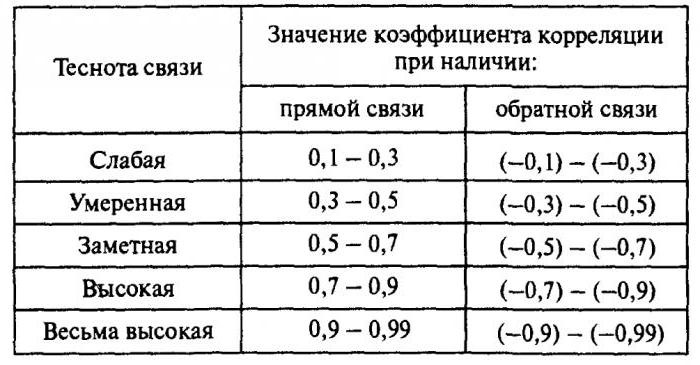

### Корреляция Пирсона + доверительный интервал


Корреляция Пирсона учитывает не только знаки отклонений, но и абсолютные значения отклонений от среднего значения.

Ковариация определяется как среднее произведение отклонений значений двух признаков от их средних значений.

$$
    cov = \frac{
        \sum_{i=1}^{n}
            (x_i - \overline{x}) (y_i - \overline{y})
    }{n-1}
$$
Для приведения значений в интервал $[-1, 1]$, ковариацию делят на проивзедение стандартных отклонений признаков.
$$
    K = \frac{cov}{S_x S_y}
$$

где $S_x^2$ - выборочная дисперсия,
$$
    S_x^2 = \frac{\sum_{i=1}^{n} (x - \overline{x})^2}{n-1}
$$

**Значимость корреляции Пирсона**
$H0$: Переменные $x$ и $y$ - некоррелированы, т.е. $K = 0$

При справедливости $H0$, статистика
$$
T = \frac{K \sqrt{n-2}}{\sqrt{1-K^2}}
$$
имеет распределение:
* при $n < 30$, распределение Стьюдента $T \sim t_{n-2}$
* при $n \ge 30$, стандартное нормальное распределени (*почему?*)
  

In [23]:
alpha = 0.05

cov = np.sum((df[col_1_name] - mean_col1)*(df[col_2_name] - mean_col2)) / (len(df) - 1)
s_x = np.sqrt(np.sum((df[col_1_name] - mean_col1)**2) / (len(df) - 1))
s_y = np.sqrt(np.sum((df[col_2_name] - mean_col2)**2) / (len(df) - 1))
K = cov / (s_x*s_y)

t_stat = K * np.sqrt(len(df) - 2) / np.sqrt(1 - K**2)

critical_value = 2.086 # По таблице, так как у нас 20 сэмплов и уровень значимости 0.05

print(f'Корреляция Пирсона: {K:.3f}')
print(f'Значение Т-статистики: {t_stat:.3f}')
print(f'Критическое значение: {critical_value}')

# доверительный интревал
z = np.arctanh(K)
t_y = stats.norm.ppf(1-alpha)
left = np.tanh(z-t_y/np.sqrt(len(df)-3))
right = np.tanh(z+t_y/np.sqrt(len(df)-3))
print(f'Доверительный интервал: ({left:.3}; {right:.3})')

if t_stat < critical_value:
    print('Гипотезу H0 принимаем')
else:
    print('Гипотезу H0 не принимаем')


Корреляция Пирсона: 0.208
Значение Т-статистики: 0.903
Критическое значение: 2.086
Доверительный интервал: (-0.185; 0.544)
Гипотезу H0 принимаем


### Корреляция Спирмена

Рангом $i$-го элемента выборки $x_i$ называется его порядковый номер $R(x_i)$ в упорядоченном ряду (вариационном ряду).

Корреляция Спирмана есть корреляция Пирсона над ранговыми наборами $(R(x_1)_, \dots, R(x_n))$ и $(R(y_n)_, \dots, R(y_1))$

$$
K = \frac{
    \sum_{i=1}^{n}
    (R(x_i) - \overline{R(x)}) \cdot (R(y_i) - \overline{R(y)})
    }
    {
        \left[
        \left( \sum_{i=1}^{n} (R(x_i) - \overline{R(x)})^2 \right)
        \cdot
        \left( \sum_{i=1}^{n} (R(y_i) - \overline{R(y)})^2 \right)
        \right]^{\frac{1}{2}}
    } =
$$
$$
= 1 - \frac{6}{n (n-1) (n+1)} \sum_{i=1}^{n} \left( R(x_i) - R(y_i)\right)^2
$$

In [25]:
rank_1 = stats.rankdata(df[col_1_name])
rank_2 = stats.rankdata(df[col_2_name])

mean_rank_1 = np.mean(rank_1)
mean_rank_2 = np.mean(rank_2)

cov = np.sum((rank_1 - mean_rank_1)*(rank_2 - mean_rank_2)) / (len(df) - 1)
s_1 = np.sqrt(np.sum((rank_1 - mean_rank_1)**2) / (len(df) - 1))
s_2 = np.sqrt(np.sum((rank_2 - mean_rank_2)**2) / (len(df) - 1))
spirmen_corr = cov / (s_1*s_2)

print(f'Корреляция Спирмена: {spirmen_corr:.3f}')

Корреляция Спирмена: 0.241


### Корреляция Кенделла

$$
K = 1 - \frac{4}{n (n-1)}
\sum_{i=1}^{n-1} \sum_{j=i+1}^{n}
\left[ [x_i < x_j] \ne [y_i < y_j] \right]
$$

In [26]:
c = 0
for i in range(len(df)-1):
    for j in range(i+1, len(df)):
        sign_1 = df[col_1_name][i] < df[col_1_name][j]
        sign_2 = df[col_2_name][i] < df[col_2_name][j]
        if sign_1 != sign_2:
            c += 1
kendel_corr = 1 - 4 / (len(df) * (len(df) - 1)) * c
print(f'Корреляция Кенделла: {kendel_corr:.3f}')

Корреляция Кенделла: 0.200


# Визуализация

#### Гистограмма

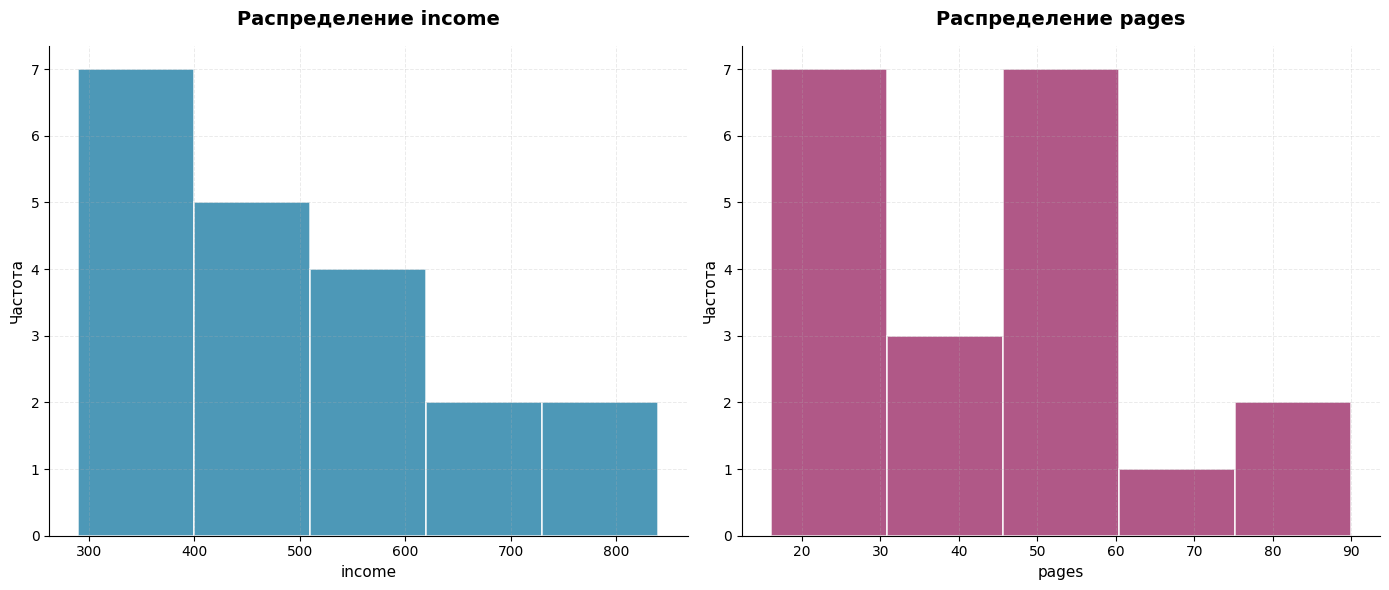

In [28]:
bin_count = int(np.floor(1 + np.log2(len(df))))

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].hist(df[col_1_name], bins=bin_count, alpha=0.85, color='#2E86AB',
             edgecolor='white', linewidth=1.2)
axes[0].set_title(f'Распределение {col_1_name}', fontsize=14, fontweight='bold', pad=15)
axes[0].set_xlabel(col_1_name, fontsize=11)
axes[0].set_ylabel('Частота', fontsize=11)
axes[0].grid(True, alpha=0.25, linestyle='--', linewidth=0.7)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

axes[1].hist(df[col_2_name], bins=bin_count, alpha=0.85, color='#A23B72',
             edgecolor='white', linewidth=1.2)
axes[1].set_title(f'Распределение {col_2_name}', fontsize=14, fontweight='bold', pad=15)
axes[1].set_xlabel(col_2_name, fontsize=11)
axes[1].set_ylabel('Частота', fontsize=11)
axes[1].grid(True, alpha=0.25, linestyle='--', linewidth=0.7)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


Визуально видно что колонки не коррелируют

#### Scatter plot

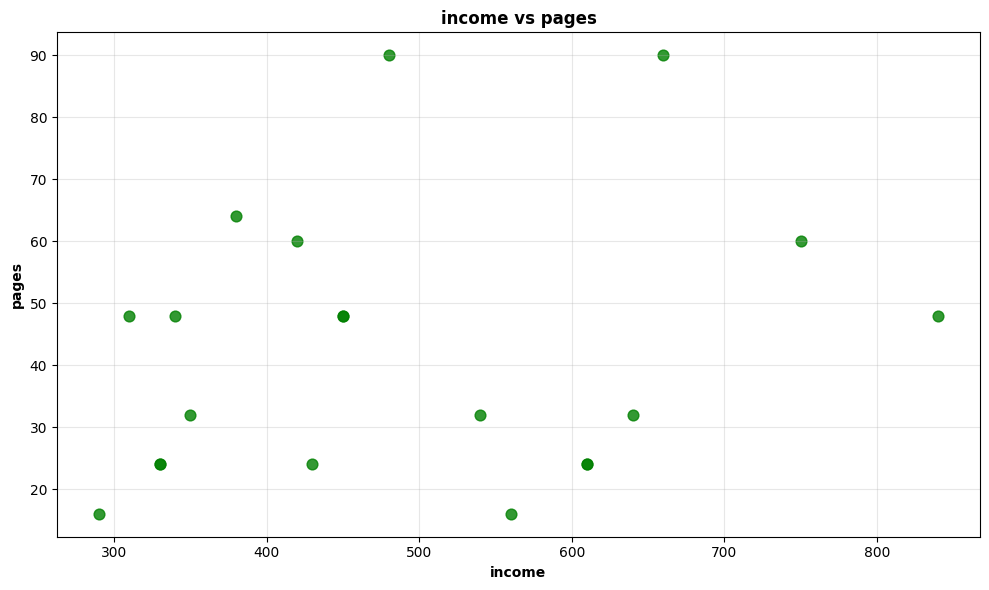

In [33]:
plt.figure(figsize=(10, 6))

plt.scatter(df[col_1_name], df[col_2_name],
           color='green', alpha=0.8, s=60)

plt.title(f'{col_1_name} vs {col_2_name}', fontweight='bold')
plt.xlabel(col_1_name, fontweight='bold')
plt.ylabel(col_2_name, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Визуально видно, что зависимости между величинами нет (что доказало отсуствие корреляции и в последствии докажут попытки построить регрессию)

#  Уравнение регрессии

$$ Q(w) = \sum_{i=1}^{n} (y_i - \hat{y}(x_i, w))^2 \rightarrow \min_{w} $$
 $$ \frac{\partial{Q}}{\partial{w}} = 0 $$

### Линейная
 $y=w_1 x + w_0$

In [46]:
def analytical_linear_regression(x, y):
    n = len(x)
    X = np.column_stack([np.ones(n), x])
    XTX = X.T @ X
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv @ X.T @ y

    w0, w1 = w
    y_pred = w0 + w1 * x

    # R²
    ss_res = np.sum((y - y_pred) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r2 = 1 - (ss_res / ss_tot)

    return w0, w1, r2, y_pred

### Квадратичная
$y = w_2 x^2 + w_1 x + w_0$

In [47]:
def analytical_quadratic_regression(x, y):
    n = len(x)
    X = np.column_stack([np.ones(n), x, x**2])
    XTX = X.T @ X
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv @ X.T @ y

    w0, w1, w2 = w
    y_pred = w0 + w1 * x + w2 * x**2

    # R²
    ss_res = np.sum((y - y_pred) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r2 = 1 - (ss_res / ss_tot)

    return w0, w1, w2, r2, y_pred

### Гиперболическая
$y = \frac{w_1}{x} + w_0$

In [48]:
def analytical_hyperbolic_regression(x, y):
    # Исключаем x = 0
    mask = x != 0
    x_clean = x[mask]
    y_clean = y[mask]
    n = len(x_clean)

    # Преобразование: y = w1/x + w0
    X = np.column_stack([np.ones(n), 1/x_clean])
    XTX = X.T @ X
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv @ X.T @ y_clean

    w0, w1 = w
    y_pred = w0 + w1 / x_clean

    # R²
    ss_res = np.sum((y_clean - y_pred) ** 2)
    ss_tot = np.sum((y_clean - np.mean(y_clean)) ** 2)
    r2 = 1 - (ss_res / ss_tot)

    return w0, w1, r2, y_pred, x_clean

### Показательная
$y = w_1^x \cdot w_0$

In [49]:
def analytical_exponential_regression(x, y):
    if not np.all(y > 0):
        return None, None, None, None, "y должен быть > 0"

    # Линеаризация: ln(y) = ln(w0) + x * ln(w1)
    # y = w0 * w1^x -> ln(y) = ln(w0) + x * ln(w1)
    log_y = np.log(y)
    n = len(x)

    X = np.column_stack([np.ones(n), x])
    XTX = X.T @ X
    XTX_inv = np.linalg.inv(XTX)
    w_log = XTX_inv @ X.T @ log_y

    ln_w0, ln_w1 = w_log
    w0 = np.exp(ln_w0)
    w1 = np.exp(ln_w1)

    y_pred = w0 * (w1 ** x)

    # R²
    ss_res = np.sum((y - y_pred) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r2 = 1 - (ss_res / ss_tot)

    return w0, w1, r2, y_pred, None

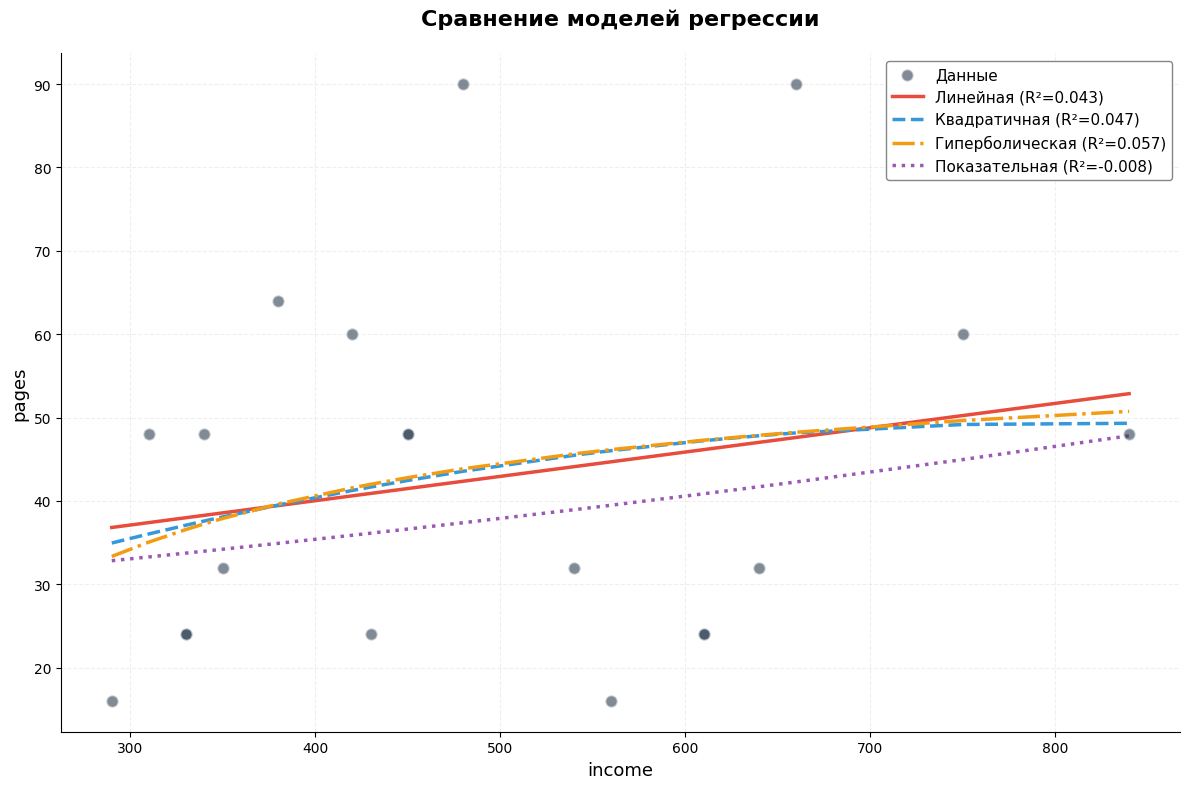


АНАЛИТИЧЕСКИЕ РЕШЕНИЯ:
Линейная:        y = 0.029187·x + 28.341912  |  R² = 0.043339
Квадратичная:    y = -0.000053·x² + 0.086384·x + 14.374048  |  R² = 0.046897
Гиперболическая: y = -7710.213904/x + 59.915835  |  R² = 0.056601
Показательная:   y = 26.916369·1.000684^x  |  R² = -0.008303


In [50]:
x = df[col_1_name].values
y = df[col_2_name].values

sort_idx = np.argsort(x)
x_sorted = x[sort_idx]

# Создаем один график
fig, ax = plt.subplots(figsize=(12, 8))

# Исходные данные
ax.scatter(x, y, alpha=0.6, color='#2C3E50', s=80, label='Данные', zorder=5, edgecolors='white', linewidth=1.5)

# 1. ЛИНЕЙНАЯ РЕГРЕССИЯ
w0_linear, w1_linear, r2_linear, y_pred_linear = analytical_linear_regression(x, y)
y_linear_sorted = w0_linear + w1_linear * x_sorted
ax.plot(x_sorted, y_linear_sorted, linewidth=2.5, color='#E74C3C',
        label=f'Линейная (R²={r2_linear:.3f})', linestyle='-')

# 2. КВАДРАТИЧНАЯ РЕГРЕССИЯ
w0_quad, w1_quad, w2_quad, r2_quad, y_pred_quad = analytical_quadratic_regression(x, y)
y_quad_sorted = w0_quad + w1_quad * x_sorted + w2_quad * x_sorted**2
ax.plot(x_sorted, y_quad_sorted, linewidth=2.5, color='#3498DB',
        label=f'Квадратичная (R²={r2_quad:.3f})', linestyle='--')

# 3. ГИПЕРБОЛИЧЕСКАЯ РЕГРЕССИЯ
w0_hyper, w1_hyper, r2_hyper, y_pred_hyper, x_hyper = analytical_hyperbolic_regression(x, y)
if x_hyper is not None:
    sort_idx_hyper = np.argsort(x_hyper)
    x_hyper_sorted = x_hyper[sort_idx_hyper]
    y_hyper_sorted = w0_hyper + w1_hyper / x_hyper_sorted
    ax.plot(x_hyper_sorted, y_hyper_sorted, linewidth=2.5, color='#F39C12',
            label=f'Гиперболическая (R²={r2_hyper:.3f})', linestyle='-.')

# 4. ПОКАЗАТЕЛЬНАЯ РЕГРЕССИЯ
result = analytical_exponential_regression(x, y)
if result[4] is None:
    w0_exp, w1_exp, r2_exp, y_pred_exp, _ = result
    y_exp_sorted = w0_exp * (w1_exp ** x_sorted)
    ax.plot(x_sorted, y_exp_sorted, linewidth=2.5, color='#9B59B6',
            label=f'Показательная (R²={r2_exp:.3f})', linestyle=':')

# Оформление
ax.set_title('Сравнение моделей регрессии', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel(col_1_name, fontsize=13)
ax.set_ylabel(col_2_name, fontsize=13)
ax.legend(loc='best', fontsize=11, framealpha=0.95, edgecolor='gray')
ax.grid(True, alpha=0.2, linestyle='--', linewidth=0.8)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

# Вывод результатов
print("\nАНАЛИТИЧЕСКИЕ РЕШЕНИЯ:")
print("=" * 70)
print(f"Линейная:        y = {w1_linear:.6f}·x + {w0_linear:.6f}  |  R² = {r2_linear:.6f}")
print(f"Квадратичная:    y = {w2_quad:.6f}·x² + {w1_quad:.6f}·x + {w0_quad:.6f}  |  R² = {r2_quad:.6f}")
if x_hyper is not None:
    print(f"Гиперболическая: y = {w1_hyper:.6f}/x + {w0_hyper:.6f}  |  R² = {r2_hyper:.6f}")
if result[4] is None:
    print(f"Показательная:   y = {w0_exp:.6f}·{w1_exp:.6f}^x  |  R² = {r2_exp:.6f}")
print("=" * 70)


# Проверка уравнения регрессии

### Критерий Фишера

$H_0$: уравнение регрессии не значимо, $w=0$

$$ F = \frac{R^2}{1-R^2} \cdot \frac{n-k}{k-1} $$
где k = 2

ПРОВЕРКА ЗНАЧИМОСТИ УРАВНЕНИЙ РЕГРЕССИИ
H0: уравнение регрессии не значимо (все коэффициенты = 0)
H1: уравнение регрессии значимо (хотя бы один коэффициент ≠ 0)

--- LINEAR РЕГРЕССИЯ ---
R² = 0.043339
F-статистика = 0.815440
Критическое значение F(1,18) = 4.413873
P-value = 0.378443
Статистически значима: НЕТ
✗ НЕ ОТВЕРГАЕМ H0: уравнение регрессии не значимо

--- QUADRATIC РЕГРЕССИЯ ---
R² = 0.046897
F-статистика = 0.418237
Критическое значение F(2,17) = 3.591531
P-value = 0.664797
Статистически значима: НЕТ
✗ НЕ ОТВЕРГАЕМ H0: уравнение регрессии не значимо

--- HYPERBOLIC РЕГРЕССИЯ ---
R² = 0.056601
F-статистика = 1.079941
Критическое значение F(1,18) = 4.413873
P-value = 0.312469
Статистически значима: НЕТ
✗ НЕ ОТВЕРГАЕМ H0: уравнение регрессии не значимо

--- EXPONENTIAL РЕГРЕССИЯ ---
R² = -0.008303
F-статистика = -0.148217
Критическое значение F(1,18) = 4.413873
P-value = 1.000000
Статистически значима: НЕТ
✗ НЕ ОТВЕРГАЕМ H0: уравнение регрессии не значимо


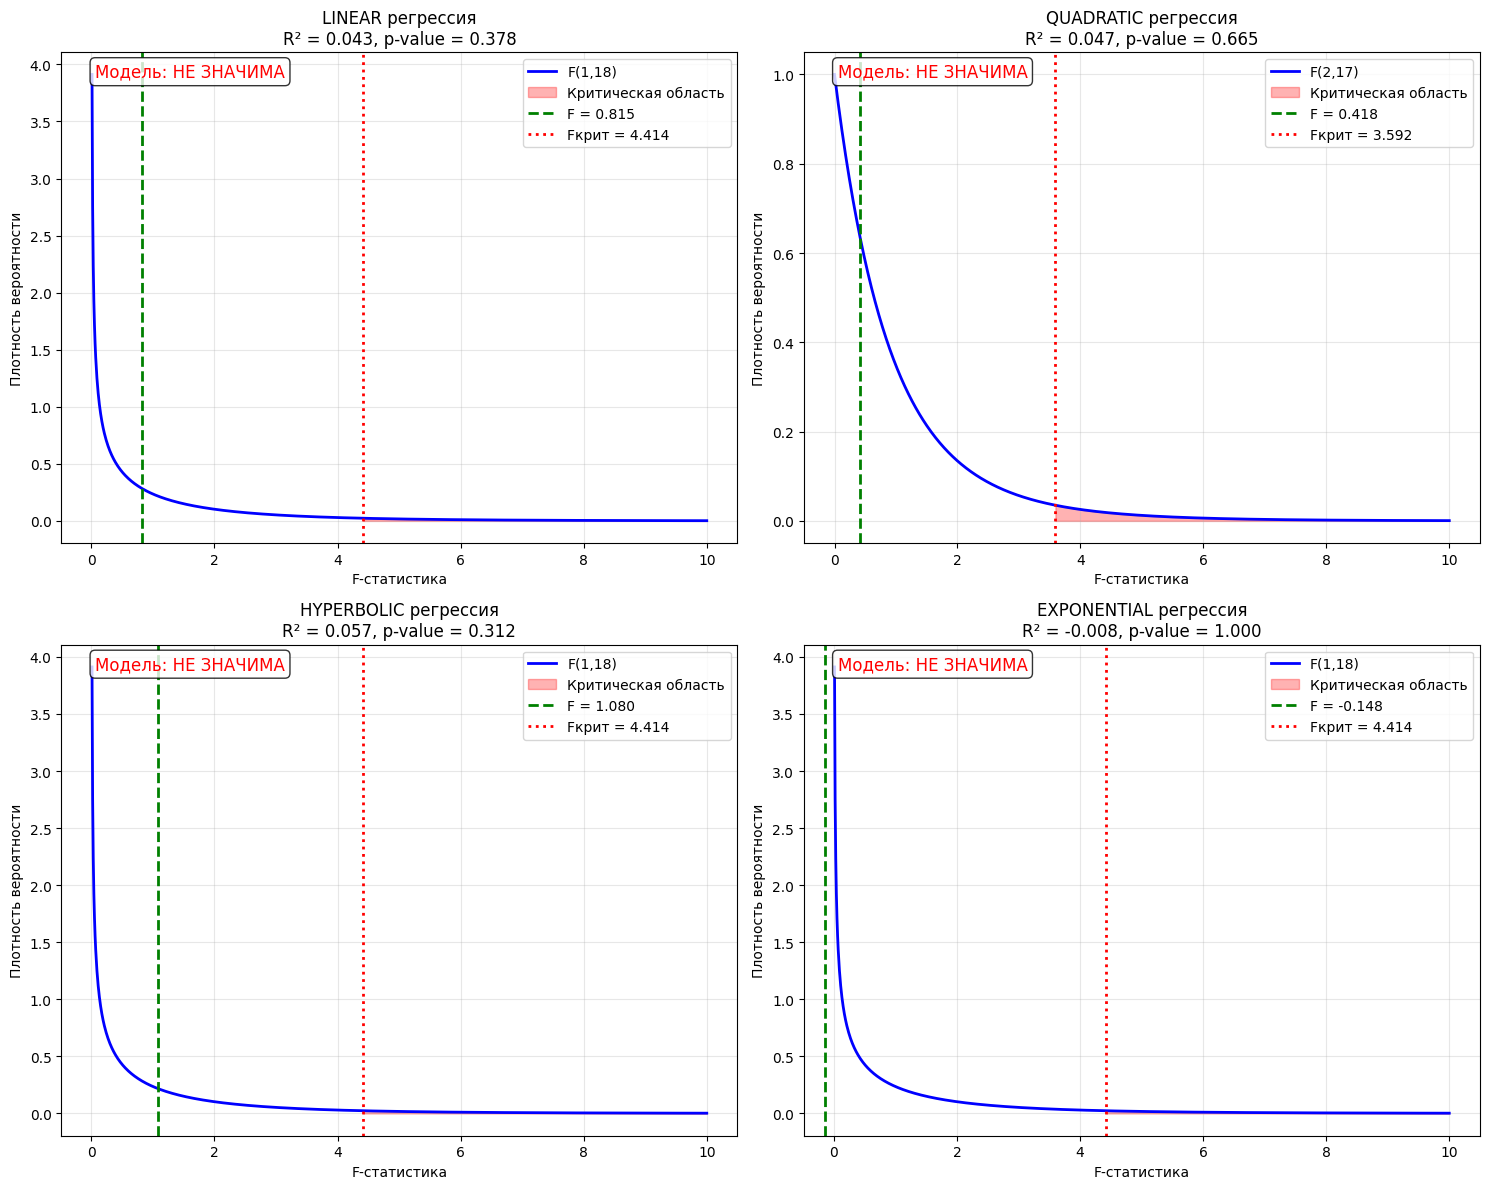


СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ ПРОВЕРКИ ЗНАЧИМОСТИ
Модель          R²       F-стат     F-крит     p-value    Результат      
--------------------------------------------------------------------------------
linear          0.0433   0.8154     4.4139     0.378443   НЕ ЗНАЧИМА ✗   
quadratic       0.0469   0.4182     3.5915     0.664797   НЕ ЗНАЧИМА ✗   
hyperbolic      0.0566   1.0799     4.4139     0.312469   НЕ ЗНАЧИМА ✗   
exponential     -0.0083  -0.1482    4.4139     1.000000   НЕ ЗНАЧИМА ✗   


In [51]:
def regression_significance_test(x, y, y_pred, model_type, alpha=0.05):
    n = len(y)

    if model_type == 'linear':
        k = 2  # w0, w1
    elif model_type == 'quadratic':
        k = 3  # w0, w1, w2
    elif model_type in ['hyperbolic', 'exponential']:
        k = 2  # w0, w1
    else:
        raise ValueError("Неизвестный тип модели")

    ss_res = np.sum((y - y_pred) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r2 = 1 - (ss_res / ss_tot)

    f_statistic = (r2 / (1 - r2)) * ((n - k) / (k - 1))

    df1 = k - 1  # степени свободы числителя
    df2 = n - k  # степени свободы знаменателя
    critical_value = stats.f.ppf(1 - alpha, df1, df2)

    p_value = 1 - stats.f.cdf(f_statistic, df1, df2)

    reject_h0 = f_statistic > critical_value

    return {
        'r2': r2,
        'f_statistic': f_statistic,
        'critical_value': critical_value,
        'p_value': p_value,
        'reject_h0': reject_h0,
        'n': n,
        'k': k,
        'df1': df1,
        'df2': df2
    }

def test_all_regressions(x, y):
    results = {}

    w0_linear, w1_linear, r2_linear, y_pred_linear = analytical_linear_regression(x, y)
    results['linear'] = regression_significance_test(x, y, y_pred_linear, 'linear')

    w0_quad, w1_quad, w2_quad, r2_quad, y_pred_quad = analytical_quadratic_regression(x, y)
    results['quadratic'] = regression_significance_test(x, y, y_pred_quad, 'quadratic')

    w0_hyper, w1_hyper, r2_hyper, y_pred_hyper, x_hyper = analytical_hyperbolic_regression(x, y)
    if x_hyper is not None:
        mask = x != 0
        y_hyper_clean = y[mask]
        results['hyperbolic'] = regression_significance_test(x_hyper, y_hyper_clean, y_pred_hyper, 'hyperbolic')

    result_exp = analytical_exponential_regression(x, y)
    if result_exp[4] is None:
        w0_exp, w1_exp, r2_exp, y_pred_exp, _ = result_exp
        results['exponential'] = regression_significance_test(x, y, y_pred_exp, 'exponential')

    return results

x = df[col_1_name].values
y = df[col_2_name].values

significance_results = test_all_regressions(x, y)

print("ПРОВЕРКА ЗНАЧИМОСТИ УРАВНЕНИЙ РЕГРЕССИИ")
print("=" * 70)
print("H0: уравнение регрессии не значимо (все коэффициенты = 0)")
print("H1: уравнение регрессии значимо (хотя бы один коэффициент ≠ 0)")
print("=" * 70)

for model_name, result in significance_results.items():
    print(f"\n--- {model_name.upper()} РЕГРЕССИЯ ---")
    print(f"R² = {result['r2']:.6f}")
    print(f"F-статистика = {result['f_statistic']:.6f}")
    print(f"Критическое значение F({result['df1']},{result['df2']}) = {result['critical_value']:.6f}")
    print(f"P-value = {result['p_value']:.6f}")
    print(f"Статистически значима: {'ДА' if result['reject_h0'] else 'НЕТ'}")

    if result['reject_h0']:
        print("✓ ОТВЕРГАЕМ H0: уравнение регрессии статистически значимо")
    else:
        print("✗ НЕ ОТВЕРГАЕМ H0: уравнение регрессии не значимо")

def plot_f_distribution(results, alpha=0.05):

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()

    models = list(results.keys())

    for i, model_name in enumerate(models):
        if i >= 4:
            break

        result = results[model_name]

        x_f = np.linspace(0, max(10, result['f_statistic'] * 1.5), 1000)
        y_f = stats.f.pdf(x_f, result['df1'], result['df2'])

        axes[i].plot(x_f, y_f, 'b-', linewidth=2, label=f'F({result["df1"]},{result["df2"]})')
        axes[i].fill_between(x_f, y_f, where=(x_f >= result['critical_value']),
                           color='red', alpha=0.3, label='Критическая область')

        axes[i].axvline(result['f_statistic'], color='green', linestyle='--',
                       linewidth=2, label=f'F = {result["f_statistic"]:.3f}')

        axes[i].axvline(result['critical_value'], color='red', linestyle=':',
                       linewidth=2, label=f'Fкрит = {result["critical_value"]:.3f}')

        axes[i].set_title(f'{model_name.upper()} регрессия\n'
                         f'R² = {result["r2"]:.3f}, '
                         f'p-value = {result["p_value"]:.3f}')
        axes[i].set_xlabel('F-статистика')
        axes[i].set_ylabel('Плотность вероятности')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)

        status = "ЗНАЧИМА" if result['reject_h0'] else "НЕ ЗНАЧИМА"
        color = "green" if result['reject_h0'] else "red"
        axes[i].text(0.05, 0.95, f'Модель: {status}',
                    transform=axes[i].transAxes, fontsize=12, color=color,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

    plt.tight_layout()
    plt.show()

plot_f_distribution(significance_results)

def create_summary_table(results):

    print("\n" + "="*80)
    print("СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ ПРОВЕРКИ ЗНАЧИМОСТИ")
    print("="*80)
    print(f"{'Модель':<15} {'R²':<8} {'F-стат':<10} {'F-крит':<10} {'p-value':<10} {'Результат':<15}")
    print("-"*80)

    for model_name, result in results.items():
        r2 = f"{result['r2']:.4f}"
        f_stat = f"{result['f_statistic']:.4f}"
        f_crit = f"{result['critical_value']:.4f}"
        p_val = f"{result['p_value']:.6f}"
        status = "ЗНАЧИМА ✓" if result['reject_h0'] else "НЕ ЗНАЧИМА ✗"

        print(f"{model_name:<15} {r2:<8} {f_stat:<10} {f_crit:<10} {p_val:<10} {status:<15}")

    print("="*80)

create_summary_table(significance_results)